# Guided HoughCircles

This notebook tests the idea of guiding the HoughCircles tracking by the results of manual tracking at a certain interval. The advantage of this method is: even if we lose the particle at some point, we will have a chance to get it back when the next manual tracking result is used. 

In the future development, cross correlation tracking will also be used to assist the HoughCircles to achieve a higher degree of automation. 

The concept of **Guided HoughCircles** is shown in the schematic below.

![guided houghcircles concept](temp/guided_tracking_concept.svg)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from corrLib import readdata
import os
from skimage import io
import cv2
from myImageLib import to8bit, show_progress
import matplotlib.patches as mpatch
from IPython.display import clear_output

In [62]:
# load manual trajectory
folder = r'C:\Users\liuzy\Documents\Data\DE\11032021'
n = 14 # exp number 
t50 = pd.read_csv(os.path.join(folder, 'Analysis', '{:02d}'.format(n), 'traj_50.csv'))
t50.head()

,particle,frame,x,y,Distance,Velocity,Pixel Value
0,1,1,493,429,-1.000,-1.000,6058
1,1,2,509,399,4.386,2.193,5877
2,1,3,519,402,1.347,0.673,7239
3,1,4,527,393,1.553,0.777,5367
4,1,5,504,378,3.542,1.771,6661


In [63]:
# load images
image_folder = os.path.join(folder, '{:02d}'.format(n))
l = readdata(image_folder, 'tif')
l.head()

,Name,Dir
0,exp100000,C:\Users\liuzy\Documents\Data\DE\11032021\14\e...
1,exp100001,C:\Users\liuzy\Documents\Data\DE\11032021\14\e...
2,exp100002,C:\Users\liuzy\Documents\Data\DE\11032021\14\e...
3,exp100003,C:\Users\liuzy\Documents\Data\DE\11032021\14\e...
4,exp100004,C:\Users\liuzy\Documents\Data\DE\11032021\14\e...


**Note:** the naming convention of the trajectory data is `traj_xx.csv`, where `xx` is the interval of manual tracking in the unit of frame.

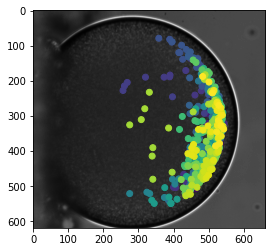

In [64]:
# preview the manual tracking data
img = io.imread(l.Dir[0])
plt.scatter(t50.x, t50.y, c=np.linspace(0, 1, len(t50)), cmap='viridis')
plt.imshow(img, cmap='gray')

In [56]:
# Read the params from structured log
D_um = 195.1
d_um = 19.2
MPP = 0.33
D = D_um / MPP
d = d_um / MPP
print("Outer diameter is {0:.1f} pixels\nInner diameter is {1:.1f} pixels".format(D, d))

Outer diameter is 591.2 pixels
Inner diameter is 58.2 pixels


In [57]:
# Modify the spaced trajectory obtained from manual tracking
interval = 50
t = t50.assign(frame=t50.index*interval)
t.head()

,particle,frame,x,y,Distance,Velocity,Pixel Value
0,1,0,515,258,-1.000,-1.000,34
1,1,50,518,260,0.465,0.233,41
2,1,100,534,281,3.406,1.703,164
3,1,150,522,306,3.577,1.789,33
4,1,200,519,307,0.408,0.204,31


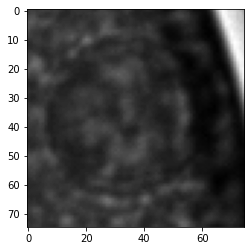

In [58]:
# One interval test
i = 0 # frame number
X = t.x[i]
Y = t.y[i]
crop_size = (int(d*1.3), int(d*1.3)) # height and width, int
crop_anchor = np.array([int(Y)-crop_size[0]//2, int(X)-crop_size[1]//2]) # upper left corner coords, int
crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
       crop_anchor[1], crop_anchor[1]+crop_size[1])
# need to check if the crop exceeds the borders of images
img = io.imread(l.Dir[i])
cropped = img[crop[0]:crop[1], crop[2]:crop[3]]
plt.imshow(cropped, cmap='gray')

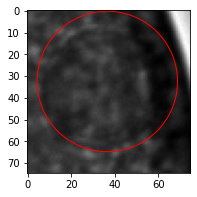

In [59]:
# Find circle in the cropped image of the next frame
i = 1
img = io.imread(l.Dir[i])
cropped = img[crop[0]:crop[1], crop[2]:crop[3]]
# plt.imshow(cropped, cmap='gray')

tol = 5
Hough_dp = 1
Hough_minDist = max(crop_size)
Hough_param2 = 1
Hough_maxRadius = int(d // 2 + tol)
Hough_minRadius = int(d // 2 - tol)
circles = cv2.HoughCircles(to8bit(cropped), cv2.HOUGH_GRADIENT, Hough_dp, Hough_minDist, 
                               param2=Hough_param2, maxRadius=Hough_maxRadius, minRadius=Hough_minRadius)
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cropped, cmap='gray')
circle_object = mpatch.Circle((circles[0, 0, 0], circles[0, 0, 1]), circles[0, 0, 2],
                             fill=False, ec='red', lw=1)
ax.add_patch(circle_object)

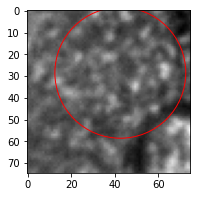

In [60]:
# test the first interval
X = t.x[0]
Y = t.y[0]
for i in range(t.frame[0]+1, t.frame[1]):
    img = io.imread(l.Dir[i])
    crop_anchor = np.array([int(Y)-crop_size[0]//2, int(X)-crop_size[1]//2])
    crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
       crop_anchor[1], crop_anchor[1]+crop_size[1])
    cropped = img[max(crop[0], 0):min(crop[1], img.shape[0]), max(crop[2], 0):min(crop[3], img.shape[1])]
    circles = cv2.HoughCircles(to8bit(cropped), cv2.HOUGH_GRADIENT, Hough_dp, Hough_minDist, 
                               param2=Hough_param2, maxRadius=Hough_maxRadius, minRadius=Hough_minRadius)
    X = crop_anchor[1] + circles[0, 0, 0]
    Y = crop_anchor[0] + circles[0, 0, 1]
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(cropped, cmap='gray')
    circle_object = mpatch.Circle((circles[0, 0, 0], circles[0, 0, 1]), circles[0, 0, 2],
                                 fill=False, ec='red', lw=1)
    ax.add_patch(circle_object)
    clear_output(wait=True)
    plt.pause(0.001)

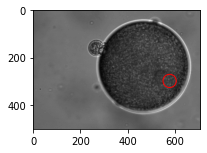

In [94]:
# test the first interval
# draw whole images
X = t.x[0]
Y = t.y[0]
v_list = []
for i in range(t.frame[0]+1, t.frame[1]):
    img = io.imread(l.Dir[i])
    crop_anchor = np.array([int(Y)-crop_size[0]//2, int(X)-crop_size[1]//2])
    crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
       crop_anchor[1], crop_anchor[1]+crop_size[1])
    cropped = img[max(crop[0], 0):min(crop[1], img.shape[0]), max(crop[2], 0):min(crop[3], img.shape[1])]
    circles = cv2.HoughCircles(to8bit(cropped), cv2.HOUGH_GRADIENT, Hough_dp, Hough_minDist, 
                               param2=Hough_param2, maxRadius=Hough_maxRadius, minRadius=Hough_minRadius)
    X = crop_anchor[1] + circles[0, 0, 0]
    Y = crop_anchor[0] + circles[0, 0, 1]
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img, cmap='gray')
    circle_object = mpatch.Circle((X, Y), circles[0, 0, 2],
                                 fill=False, ec='red', lw=1)
    ax.add_patch(circle_object)
    clear_output(wait=True)
    plt.pause(0.001)
    
    v = ((circles[0,0,0]-crop_size[0]/2) ** 2 + (circles[0,0,1]-crop_size[1]/2) ** 2) ** 0.5
    v_list.append(v)

**Comments:** in the first interval, I lost track of the inner droplet in the middle. Certainly, HoughCircles is not an ideal method for this job. For now, I'm going to continue to implement the guided tracking for a whole image sequence using HoughCircles. Then, I will come back to implement the cross correlation method, which is supposed to have better accuracy.

In [61]:
# Initial params
# crop_anchor = np.array([190, 140]) # upper left corner coords, int
# crop_size = (90, 90) # height and width, int
save_crop_step = 10 # save cropped image every save_crop_step steps, int
start_frame = 0
end_frame = None
num_images = len(l)
# HoughCircles params
# Hough_dp = 1
# Hough_minDist = max(crop_size)
# Hough_param2 = 1.2
# Hough_maxRadius = 40
# Hough_minRadius = 30

# initialize result containers
x_list = [] # x of circle
y_list = [] # y of circle
filename_list = [] # filename of raw image
nc_list = [] # number of circles detected in each frame

# initialize output folder
main_output_folder = os.path.join(folder, 'Analysis', '{:02d}'.format(n))
cropped_folder = os.path.join(main_output_folder, 'cropped')
if os.path.exists(main_output_folder) == False:
    os.makedirs(main_output_folder)
if os.path.exists(cropped_folder) == False:
    os.makedirs(cropped_folder)

print("start working on {}".format(folder))

for num, i in l.iterrows():
    if num < start_frame:
        continue
    # read image and convert to 8-bit (HoughCircles requires 8-bit images)
    img = to8bit(io.imread(i.Dir))

    # set crop using crop_anchor and crop_size
    # this will use either the manual tracking result (guide), or the result from previous step
    if num in np.array(t.frame): # if frame number examined here is in the manual tracking result (guide), use it
        crop_anchor = np.array([int(t.y.loc[t.frame==num])-crop_size[0]//2, int(t.x.loc[t.frame==num])-crop_size[1]//2])
        crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
           crop_anchor[1], crop_anchor[1]+crop_size[1])
        cropped = img[max(crop[0], 0):min(crop[1], img.shape[0]), max(crop[2], 0):min(crop[3], img.shape[1])]
        y, x = float(t.y.loc[t.frame==num]), float(t.y.loc[t.frame==num])
        filename_list.append(i.Name)
        x_list.append(x)
        y_list.append(y)
        fig = plt.figure(figsize=(3, 3))
        ax = fig.add_axes([0,0,1,1])
        ax.imshow(cropped, cmap='gray')
        circle_object = mpatch.Circle((x, y), 10,
                                     fill=False, ec='red', lw=1)
        ax.add_patch(circle_object)
        fig.savefig(os.path.join(cropped_folder, '{}.jpg'.format(i.Name)))
#             plt.close() # prevent figure from showing up inline
        plt.pause(0.001)
        show_progress(num/num_images)
        continue
        
    crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
           crop_anchor[1], crop_anchor[1]+crop_size[1])
    # need to check if the crop exceeds the borders of images
    cropped = img[max(crop[0], 0):min(crop[1], img.shape[0]), max(crop[2], 0):min(crop[3], img.shape[1])]
    # use HoughCircles to detect circles in the cropped image
    circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, Hough_dp, Hough_minDist, 
                               param2=Hough_param2, maxRadius=Hough_maxRadius, minRadius=Hough_minRadius)
    if circles is not None: # check if any circle is detected
        x, y = circles[0, 0, 0]+crop_anchor[1], circles[0, 0, 1]+crop_anchor[0]
        # NOTE: the circle coords given by HoughCircles is in (x, y), i.e. horizontal then vertical 
        #       to be consistent with the row-column coords, we need to put circles[0,0,1] as the "row" #
        #       and circles[0,0,0] as the "column" #
        
        # update crop_anchor with the position of circle detected
        crop_anchor = np.array([y-crop_size[1]/2, x-crop_size[0]/2]).astype('int')
        if num % save_crop_step == 0: # save cropped image and detecting result for validating purpose
            fig = plt.figure(figsize=(3, 3))
            ax = fig.add_axes([0,0,1,1])
            ax.imshow(cropped, cmap='gray')
            circle_object = mpatch.Circle((circles[0, 0, 0], circles[0, 0, 1]), circles[0, 0, 2],
                                         fill=False, ec='red', lw=1)
            ax.add_patch(circle_object)
            fig.savefig(os.path.join(cropped_folder, '{}.jpg'.format(i.Name)))
            plt.close() # prevent figure from showing up inline
            plt.pause(0.001)
            show_progress(num/num_images)
            clear_output(wait=True)
    else:
        # if no circle is detected, set x, y to NaN
        x, y = np.nan, np.nan
    
    # record information from each step in lists
    filename_list.append(i.Name)
    x_list.append(x)
    y_list.append(y) 
        
    # check end_frame
    if end_frame is not None:
        if num >= end_frame-1:
            break

data = pd.DataFrame({'x':x_list, 'y':y_list, 'filename':filename_list})
data.to_csv(os.path.join(main_output_folder, 'traj_1.csv'), index=False)

 [###########################################################-] 100.0%


In [32]:
data.to_csv(os.path.join(main_output_folder, 'traj_1.csv'), index=False)

In [137]:
# Reorganize the program with functions
def imfindcircle(img, radius, tol):
    """Find a circle in given image using HoughCircles method
    Args:
    img -- input 8-bit image
    radius -- radius of circle to look for (px)
    tol -- tolerance of the circle radius (px), the circle looked for will be in range (radius-tol, radius+tol)
    Returns:
    (x, y) -- if a circle is found, return the coordinates of the circle
    None -- if no circle is found, return None"""
    
    tol = 5
    Hough_dp = 1
    Hough_minDist = max(img.shape)
    Hough_param2 = 1.2
    Hough_maxRadius = int(d // 2 + tol)
    Hough_minRadius = int(d // 2 - tol)
    circles = cv2.HoughCircles(to8bit(cropped), cv2.HOUGH_GRADIENT, Hough_dp, Hough_minDist, 
                                   param2=Hough_param2, maxRadius=Hough_maxRadius, minRadius=Hough_minRadius)
    if circles is not None:
        return circles[0, 0, 0], circles[0, 0, 1]
    else:
        return None

In [201]:
data[::50]

,x,y,filename
0,575.5,307.5,exp100000
50,539.5,279.5,exp100050


In [113]:
t

,,Area,X,Y,Major,Minor,Angle,frame
0,1,2561,575.5,307.5,57.103,57.103,0,0
1,2,2561,539.5,279.5,57.103,57.103,0,50
2,3,2561,495.5,325.5,57.103,57.103,0,100
3,4,2561,476.5,337.5,57.103,57.103,0,150
4,5,2561,467.5,354.5,57.103,57.103,0,200
...,...,...,...,...,...,...,...,...
605,606,2561,504.5,200.5,57.103,57.103,0,30250
606,607,2561,487.5,152.5,57.103,57.103,0,30300
607,608,2561,468.5,202.5,57.103,57.103,0,30350
608,609,2561,534.5,191.5,57.103,57.103,0,30400


In [115]:
1 in np.array(t.frame)

False

In [147]:
from corrTrack import *
from xcorr_funcs import *

In [188]:
I1 = io.imread(l.Dir[53])
I0 = io.imread(l.Dir[50])
crop_anchor = np.array([int(t.Y.loc[t.frame==50])-crop_size[0]//2, int(t.X.loc[t.frame==50])-crop_size[1]//2])
crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
           crop_anchor[1], crop_anchor[1]+crop_size[1])
mask = I0[max(crop[0], 0):min(crop[1], I1.shape[0]), max(crop[2], 0):min(crop[3], I1.shape[1])]
img = I1[max(crop[0], 0):min(crop[1], I1.shape[0]), max(crop[2], 0):min(crop[3], I1.shape[1])]

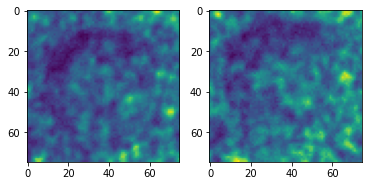

In [189]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(mask)
ax[1].imshow(img)

In [190]:
max_coor, pk_value = track_spheres(img, mask, 1)

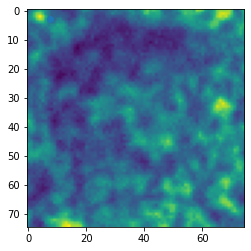

In [191]:
plt.imshow(img)
plt.scatter(max_coor[0, 0], max_coor[1, 0])

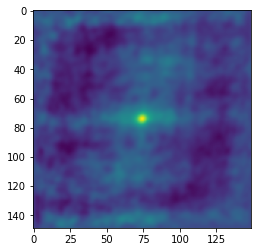

In [160]:
corr = normxcorr2(mask, img, mode='full')
plt.imshow(-corr)

In [161]:
cent = FastPeakFind(-corr)
peaks = corr[cent[0], cent[1]]
ind = maxk(peaks, 3)
max_coor_tmp = cent[:, ind]
max_coor = max_coor_tmp.astype('float32')
pk_value = peaks[ind]  

In [162]:
max_coor

array([[ 30.,  41., 141.],
       [ 63.,   1., 105.]], dtype=float32)

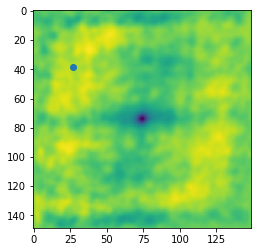

In [153]:
plt.imshow(corr)
plt.scatter(max_coor[0, 0], max_coor[1, 0])